Downloading & unpacking dataset

In [1]:
import os
import requests
import tarfile

In [3]:
# Define the URL of the dataset and the target directory
url = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
dataset_tar = 'speech_commands_v0.02.tar.gz'
extract_path = 'speech_commands'

# Download the dataset if it doesn't already exist
if not os.path.exists(dataset_tar):
    print(f"Downloading {dataset_tar}...")
    response = requests.get(url, stream=True)
    with open(dataset_tar, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print(f"\n{dataset_tar} downloaded.")
else:
    print(f"{dataset_tar} already exists.")

# Extract the dataset if it hasn't been extracted already
if not os.path.exists(extract_path):
    print(f"Extracting {dataset_tar}...")
    with tarfile.open(dataset_tar, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete.")
else:
    print(f"Dataset already extracted at {extract_path}.")


speech_commands_v0.02.tar.gz already exists.
Dataset already extracted at speech_commands.


Reading labelled directories

In [4]:
import os
import librosa
import tensorflow as tf
import numpy as np

In [92]:
# Define the data directory
data_dir = 'speech_commands'

# Define a dictionary to map labels to integers (optional for categorical labels)
#labels = {word: i for i, word in enumerate(os.listdir(data_dir))}
# Declare labels manually
labels = {
    'eight': 0,
    'five': 1,
    'four': 2,
    'nine': 3,
    'one': 4,
    'seven': 5,
    'six': 6,
    'three': 7,
    'two': 8,
    'zero': 9
}


In [93]:
print(labels)
print(len(labels))

{'eight': 0, 'five': 1, 'four': 2, 'nine': 3, 'one': 4, 'seven': 5, 'six': 6, 'three': 7, 'two': 8, 'zero': 9}
10


In [7]:
def load_data(data_dir, labels, max_len=None):
  """Loads audio files, assigns labels, and pads data to a specified maximum length.

  Args:
    data_dir: Path to the directory containing speech command subdirectories.
    labels: Dictionary mapping words to their integer labels (optional).
    max_len: Maximum length for padding audio data (in samples) (optional).

  Returns:
    A tuple containing three lists: padded audio data, original lengths, and corresponding labels.
  """

  padded_audio = []
  original_lengths = []
  target_labels = []

  for word, label in labels.items():
    word_dir = os.path.join(data_dir, word)

    for filename in os.listdir(word_dir):
      filepath = os.path.join(word_dir, filename)
      if not filepath.endswith('.wav'):
        continue  # Skip non-wav files

      y, sr = librosa.load(filepath, sr=None)  # Load without resampling

      original_lengths.append(len(y))  # Store original length

      # Pad audio data with zeros if necessary
      if max_len is not None and len(y) < max_len:
        padding = np.zeros(max_len - len(y))
        y_padded = np.concatenate((y, padding))
      else:
        y_padded = y  # No padding needed

      padded_audio.append(y_padded)
      target_labels.append(label)

  return padded_audio, original_lengths, target_labels


In [10]:
def load_data_by_portions(data_dir, labels, max_len=None, portion_index=1, total_portions=1):
    """Loads audio files, assigns labels, and pads data to a specified maximum length.

    Args:
        data_dir: Path to the directory containing speech command subdirectories.
        labels: Dictionary mapping words to their integer labels.
        max_len: Maximum length for padding audio data (in samples) (optional).
        portion_index: The index of the portion to load (1-based index).
        total_portions: The total number of portions to divide the dataset into.

    Returns:
        A tuple containing three lists: padded audio data, original lengths, and corresponding labels.
    """

    if portion_index < 1 or portion_index > total_portions:
        raise ValueError("portion_index must be between 1 and total_portions")

    padded_audio = []
    original_lengths = []
    target_labels = []

    for word, label in labels.items():
        word_dir = os.path.join(data_dir, word)
        files = [f for f in os.listdir(word_dir) if f.endswith('.wav')]

        # Calculate the size of each portion
        portion_size = len(files) // total_portions
        start_index = (portion_index - 1) * portion_size
        end_index = start_index + portion_size

        if portion_index == total_portions:  # Handle the last portion
            end_index = len(files)

        for filename in files[start_index:end_index]:
            filepath = os.path.join(word_dir, filename)
            y, sr = librosa.load(filepath, sr=None)  # Load without resampling

            original_lengths.append(len(y))  # Store original length

            # Pad audio data with zeros if necessary
            if max_len is not None and len(y) < max_len:
                padding = np.zeros(max_len - len(y))
                y_padded = np.concatenate((y, padding))
            else:
                y_padded = y  # No padding needed

            padded_audio.append(y_padded)
            target_labels.append(label)

    return padded_audio, original_lengths, target_labels

In [13]:
# Load the data using the defined function

#padded_audio, original_lengths, target_labels = load_data_by_portions(data_dir, labels, 16000)
padded_audio, original_lengths, target_labels = load_data_by_portions(data_dir, labels, 16000, 2, 5)

In [14]:
print(len(target_labels))

7778


In [15]:
# Calculate the maximum length of features
max_length = max(len(padded_audi) for padded_audi in padded_audio)
min_length = min(len(padded_audi) for padded_audi in padded_audio)
print("Maximum length of features:", max_length)
print("Minimum length of features:", min_length)

Maximum length of features: 16000
Minimum length of features: 16000


In [16]:
# Convert features and labels to tensors for TensorFlow compatibility
#padded_audio_tensor = tf.convert_to_tensor(padded_audio)
target_labels_tensor = tf.convert_to_tensor(target_labels)

In [17]:
# Print the shape of the tensors
#print("Shape of padded_audio tensor:", padded_audio_tensor.shape)
print("Shape of target_labels_tensor:", target_labels_tensor.shape)

Shape of target_labels_tensor: (7778,)


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import librosa.display

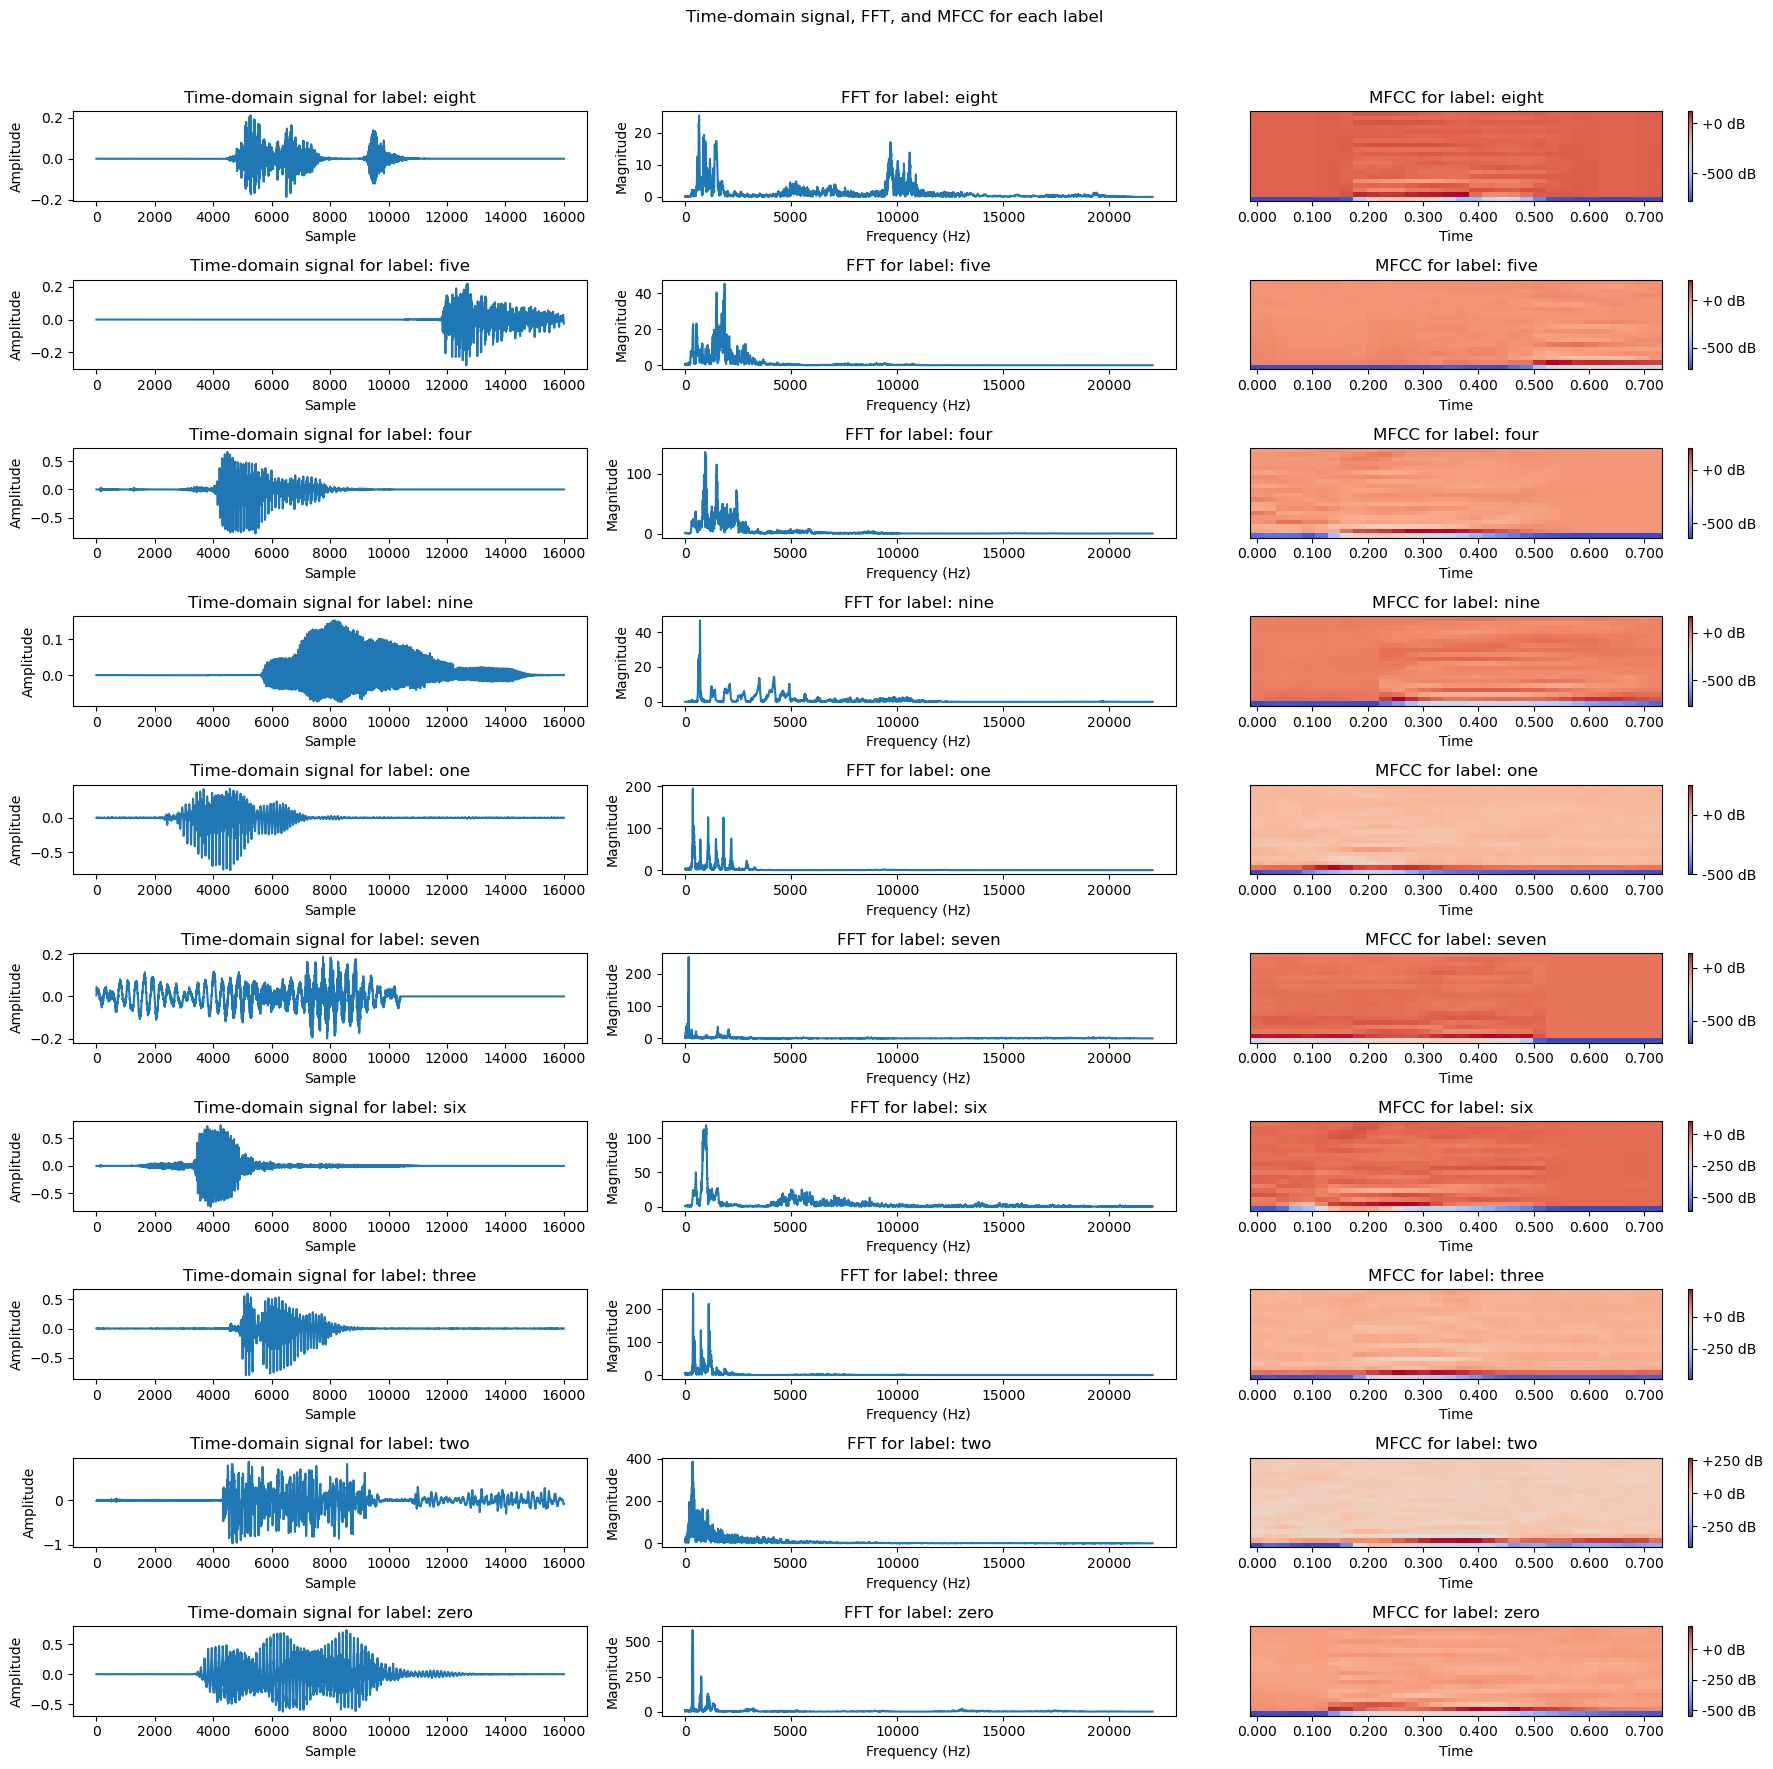

In [19]:
def plot_examples(features, target_labels, labels):
    """
    Plots time-domain signals, FFTs, and MFCCs for one example of each label.

    Args:
        features: List or array of audio features.
        target_labels: List or array of corresponding labels.
        labels: Dictionary mapping words to their integer labels.
    """
    # Reverse the labels dictionary to map integers to label names
    label_names = {v: k for k, v in labels.items()}

    # Find one example for each label
    example_indices = {label: None for label in labels.values()}
    for i, label in enumerate(target_labels):
        if example_indices[label] is None:
            example_indices[label] = i
        if all(v is not None for v in example_indices.values()):
            break

    # Plot time-domain signal, FFT, and MFCC for each example
    fig, axes = plt.subplots(len(labels), 3, figsize=(18, 18))
    fig.suptitle('Time-domain signal, FFT, and MFCC for each label')

    for i, (label, index) in enumerate(example_indices.items()):
        ax_time = axes[i, 0]
        ax_fft = axes[i, 1]
        ax_mfcc = axes[i, 2]

        # Get the example audio and label
        audio = features[index]
        label_name = label_names[label]

        # Plot the time-domain signal
        ax_time.plot(audio)
        ax_time.set_title(f'Time-domain signal for label: {label_name}')
        ax_time.set_xlabel('Sample')
        ax_time.set_ylabel('Amplitude')

        # Compute and plot the FFT
        fft = np.fft.fft(audio)
        freqs = np.fft.fftfreq(len(fft), d=1/44100)  # Compute frequency bins correctly
        ax_fft.plot(freqs[:len(freqs)//2], np.abs(fft)[:len(freqs)//2])  # Plot up to Nyquist frequency
        ax_fft.set_title(f'FFT for label: {label_name}')
        ax_fft.set_xlabel('Frequency (Hz)')
        ax_fft.set_ylabel('Magnitude')

        # Compute and plot the MFCCs
        sr = 44100  # Assuming a sample rate of 44.1 kHz
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
        img = librosa.display.specshow(mfccs, x_axis='time', ax=ax_mfcc)
        ax_mfcc.set_title(f'MFCC for label: {label_name}')
        fig.colorbar(img, ax=ax_mfcc, format='%+2.0f dB')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
    plt.show()

# Assuming `features` and `target_labels` are loaded from the previous steps
# Also assuming `labels` dictionary is {'one': 0, 'seven': 1, 'two': 2}
plot_examples(padded_audio, target_labels, labels)


In [20]:
# Get dimensions
#padded_audio_shape = padded_audio_tensor.shape
target_labels_shape = target_labels_tensor.shape

#print("Shape of padded_audio_tensor:", padded_audio_shape)
print("Shape of target_labels_tensor:", target_labels_shape)

Shape of target_labels_tensor: (7778,)


In [21]:
# Parameters for the STFT
n_fft = 2048  # Number of FFT components
hop_length = 512  # Number of samples between successive frames

# Function to convert audio signal to spectrogram
def audio_to_spectrogram(audio):
    # Compute the STFT
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    # Convert the complex-valued STFT to magnitude spectrogram
    spectrogram = np.abs(stft)
    return spectrogram

# Apply the conversion to all audio samples
spectrograms = np.array([audio_to_spectrogram(audio) for audio in padded_audio])

#print("Shape of original padded_audio_tensor:", padded_audio_tensor.shape)
print("Shape of spectrograms:", spectrograms.shape)


Shape of spectrograms: (7778, 1025, 32)


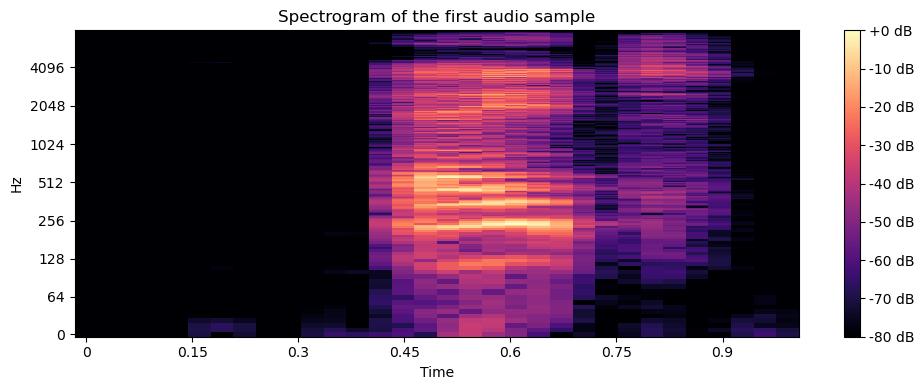

In [22]:
# Optional: Visualize the first spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(spectrograms[1], ref=np.max), sr=16000, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of the first audio sample')
plt.tight_layout()
plt.show()

In [23]:
del data_dir
del dataset_tar
del extract_path
del hop_length
del labels
del max_length
del min_length
del n_fft
del original_lengths
#del padded_audio
#del padded_audio_shape
#del padded_audio_tensor
#del spectrograms
del target_labels
del target_labels_shape
# del target_labels_tensor
del url


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split


In [25]:
# Ensure data is in the correct format
#spectrograms = np.asarray(spectrograms)
target_labels_tensor = np.asarray(target_labels_tensor)

# Reshape spectrograms to add the channel dimension
spectrograms = spectrograms[..., np.newaxis]  # Shape (11768, 1025, 32, 1)

# Split data into training and validation sets
# Split data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(spectrograms, target_labels_tensor, test_size=0.1, random_state=42)
# Split training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)


In [26]:
model_path = 'model'

In [27]:
# Check if the model already exists
if os.path.exists(model_path):
    print("Loading existing model...")
    model = load_model(model_path)
else:
    print("Creating a new model...")
    # Define the CNN model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(spectrograms.shape[1], spectrograms.shape[2], 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(labels), activation='softmax')  # Assuming 10 classes is len(labels)
    ])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(filepath=model_path,
                                      save_freq='epoch',
                                      save_best_only=False,  # Save the model at the end of every epoch
                                      save_format='tf')


Loading existing model...


In [23]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(filepath=model_path,
                                      save_freq='epoch',
                                      save_best_only=False,  # Save the model at the end of every epoch
                                      save_format='tf')

In [24]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,  # Adjust the number of epochs as needed
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, checkpoint_callback])


Epoch 1/50
186/186 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.8012

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


186/186 [==============================] - 3104s 17s/step - loss: 0.6238 - accuracy: 0.8012 - val_loss: 0.3484 - val_accuracy: 0.9029
Epoch 2/50
186/186 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.8338

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


186/186 [==============================] - 132s 710ms/step - loss: 0.5124 - accuracy: 0.8338 - val_loss: 0.3304 - val_accuracy: 0.9029
Epoch 3/50
186/186 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8541

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


186/186 [==============================] - 129s 696ms/step - loss: 0.4274 - accuracy: 0.8541 - val_loss: 0.3174 - val_accuracy: 0.8971
Epoch 4/50
186/186 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8588

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


186/186 [==============================] - 132s 708ms/step - loss: 0.4042 - accuracy: 0.8588 - val_loss: 0.3179 - val_accuracy: 0.8943
Epoch 5/50
186/186 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.8756

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


186/186 [==============================] - 133s 713ms/step - loss: 0.3540 - accuracy: 0.8756 - val_loss: 0.2842 - val_accuracy: 0.9057
Epoch 6/50
186/186 [==============================] - ETA: 0s - loss: 0.3120 - accuracy: 0.8897

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


186/186 [==============================] - 131s 702ms/step - loss: 0.3120 - accuracy: 0.8897 - val_loss: 0.2896 - val_accuracy: 0.9076
Epoch 7/50
186/186 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.8929

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


186/186 [==============================] - 140s 755ms/step - loss: 0.3034 - accuracy: 0.8929 - val_loss: 0.2818 - val_accuracy: 0.9067
Epoch 8/50
186/186 [==============================] - ETA: 0s - loss: 0.2768 - accuracy: 0.9057

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


186/186 [==============================] - 137s 737ms/step - loss: 0.2768 - accuracy: 0.9057 - val_loss: 0.2792 - val_accuracy: 0.9086
Epoch 9/50
 43/186 [=====>........................] - ETA: 1:42 - loss: 0.2291 - accuracy: 0.9244

KeyboardInterrupt: 

In [ ]:
# Save the model in TensorFlow SavedModel format
model.save('model')

# Save the model in HDF5 format
model.save('model.h5')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [28]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
#print(f'Validation Loss: {val_loss:.4f}')
#print(f'Validation Accuracy: {val_accuracy:.4f}')

test_loss, test_accuracy = model.evaluate(X_test, y_test)
#print(f'Test Loss: {val_loss:.4f}')
#print(f'Test Accuracy: {val_accuracy:.4f}')

25/25 [==============================] - 3s 136ms/step - loss: 0.4350 - accuracy: 0.8753


In [26]:
# Save the model in TensorFlow SavedModel format
model.save('model')

# Save the model in HDF5 format
#model.save('model.h5')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [29]:
saved_model_dir = 'model'

In [30]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [77]:
# Define the path where you want to save the converted TensorFlow Lite model
tflite_model_path = 'tflite_quant_model.tflite'

In [ ]:
# Save the TensorFlow Lite model to disk
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_quant_model)

print(f'TensorFlow Lite model saved to {tflite_model_path}')

In [78]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

In [79]:
# Convert data to float32 if not already
X_train_val_lite = np.array(X_train_val, dtype=np.float32)
X_test_lite = np.array(X_test, dtype=np.float32)

# Get input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

In [47]:
# Assuming X_train_val and X_test are already defined with correct shapes
X_train_val_lite = X_train_val.reshape((X_train_val.shape[0], 1025, 32, 1)).astype(np.float32)
X_test_lite = X_test.reshape((X_test.shape[0], 1025, 32, 1)).astype(np.float32)


In [80]:
print(input_details)
print(output_details)

{'name': 'serving_default_conv2d_input:0', 'index': 0, 'shape': array([   1, 1025,   32,    1]), 'shape_signature': array([  -1, 1025,   32,    1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 17, 'shape': array([ 1, 10]), 'shape_signature': array([-1, 10]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [81]:
print(X_train_val_lite[0:1].shape)

(1, 1025, 32, 1)


In [73]:
# Evaluate on validation data
interpreter.set_tensor(input_details['index'], X_train_val_lite[2:3])
interpreter.invoke()
val_predictions = interpreter.get_tensor(output_details['index'])

val_accuracy = (np.argmax(val_predictions, axis=1) == y_train_val[2:3]).mean()
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 1.0000


In [90]:
import numpy as np
import tensorflow as tf

def evaluate_tflite_model(interpreter, X_data, y_data):
    # Get input and output details
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Initialize variables to accumulate loss and accuracy
    total_loss = 0.0
    total_accuracy = 0.0
    num_samples = len(X_data)

    for i in range(num_samples):
        interpreter.set_tensor(input_details['index'], X_data[i:i+1])
        interpreter.invoke()
        
        # Get predictions
        predictions = interpreter.get_tensor(output_details['index'])

        # Compute accuracy
        accuracy = (np.argmax(predictions, axis=1) == y_data[i:i+1]).mean()
        total_accuracy += accuracy

        # Compute loss (using cross-entropy)
        y_true = np.eye(predictions.shape[1])[y_data[i:i+1]].astype(np.float32)
        y_true = np.expand_dims(y_true, axis=0)  # Add batch dimension to y_true
        loss = tf.keras.losses.categorical_crossentropy(y_true[0], predictions).numpy().mean()
        total_loss += loss

    # Calculate average loss and accuracy
    avg_loss = total_loss / num_samples
    avg_accuracy = total_accuracy / num_samples

    return avg_loss, avg_accuracy

# Assuming X_train_val_lite, y_train_val, X_test_lite, and y_test are already defined
val_loss, val_accuracy = evaluate_tflite_model(interpreter, X_train_val_lite, y_train_val)
test_loss, test_accuracy = evaluate_tflite_model(interpreter, X_test_lite, y_test)

print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Validation Loss: 0.4421
Validation Accuracy: 0.8771
Test Loss: 0.4976
Test Accuracy: 0.8650
